In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib import dates
from typing import List
from pandas.plotting import scatter_matrix
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import mutual_info_classif, VarianceThreshold 

In [2]:
def load_data(data_fname: str) -> pd.DataFrame:
    """
    Loading data. 
    """
    data = pd.read_csv(data_fname, sep=',')

    return data

In [3]:
def create_time_features(df: pd.DataFrame, column_name: str) -> pd.DataFrame:
    """
    Create columns: hours, minutes, seconds. Split a date column by date and time.
    """
    df_data = pd.to_datetime(df[column_name], format = "%Y-%m-%d %H:%M:%S")
    df['hour'] = df_data.dt.hour
    df['minute'] = df_data.dt.minute
    df['second'] = df_data.dt.second
    df['time'] = df[column_name].str.split().apply(lambda x: x[1])
    df['date'] = df[column_name].str.split().apply(lambda x: x[0])
    
    return df

In [4]:
def save_data(data: pd.DataFrame, file_name: str):
    """
    Save data to file.
    """
    data.to_csv(file_name, sep=',')

### Loading and exploring data

In [5]:
fname_calibration = "G2.csv.xls"
fname_test = "test.csv.xls"
calibration = load_data(fname_calibration)
test = load_data(fname_test)

In [6]:
calibration.describe()

,SO2op1,SO2op2,T,SO2,NO2
count,156.000000,156.000000,156.000000,156.000000,156.000000
mean,324.248212,345.540891,20.936311,89.025641,334.769231
std,57.052503,0.351442,0.136996,158.247742,438.963381
min,234.286000,344.685000,20.781500,0.000000,0.000000
25%,284.888000,345.245750,20.844000,0.000000,0.000000
50%,353.593000,345.592500,20.875000,0.000000,0.000000
75%,376.545750,345.815000,21.125000,224.000000,544.000000
max,390.261000,346.267000,21.187500,448.000000,1088.000000


In [7]:
test.describe()

,SO2op1,SO2op2,T,NO2
count,864.000000,864.000000,864.000000,864.000000
mean,349.137315,345.137569,11.457517,47.368465
std,0.576363,0.353824,1.884068,12.585284
min,347.100000,343.040000,9.000000,14.723622
25%,348.780000,344.920000,9.902500,39.500451
50%,349.100000,345.160000,11.080000,44.851663
75%,349.460000,345.370000,12.352500,52.257360
max,352.560000,346.080000,16.030000,87.887305


There are no gaps in the sets.

The training set has many duplicates and only three unique SO2 and NO2 values.

The spreads in SO2op2 in the training and test sets are practically the same, although the NO2 values differ significantly, and the average temperature differs by 10 degrees. There are suggestions that this sign can be thrown out.

The remaining features have too different stds; standardization may be required.

#### Let's separate the date and time

In [8]:
calibration = create_time_features(calibration, 'date')
test = create_time_features(test, 'date')

#### Feature Selection

Our task, if we use linear regression, is to select features that are highly correlated with the target variable, but not correlated with each other.

Let's draw correlation matrices for the training and test sets.

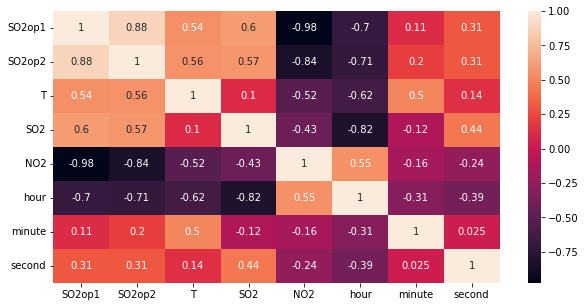

In [11]:
fig = plt.subplots(figsize=(10, 5))
sns.heatmap(calibration.corr(), annot=True)
plt.show()

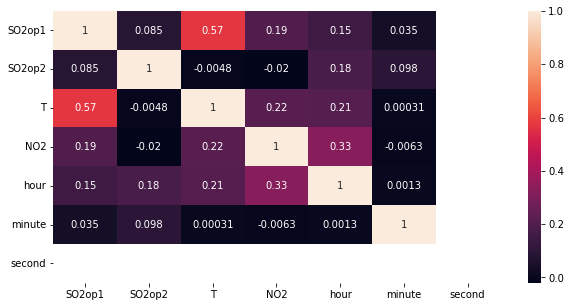

In [13]:
fig = plt.subplots(figsize=(10, 5))
sns.heatmap(test.corr(), annot=True)
plt.show()

In the training set, the target variable has a correlation with the features SO2op1, SO2op2 (0.6, 0.57, respectively), however, these features also have a high correlation with each other (0.88), and even higher than the correlations with the target variable. It is interesting to note that in the test set there is no correlation between SO2op1 and SO2op2 (0.085).

In the test set, the trait SO2op2 correlates less with T and NO2 (-0.0048 and -0.02) than SO2op1 (0.57 and 0.19), although in the training set the correlations of SO2op1 and SO2op2 with T and NO2 are almost the same (0.54, -0.98 and 0.56, - 0.84, respectively).
In this sense, it is difficult to assess from the training and test sets which of the two highly correlated features SO2op1, SO2op2 should be chosen, so I choose SO2op1, since it has a higher std + it was said that it interacts with the analyte, therefore, presumably better reflects the relationship with target variable.

If we consider the NO2 trait, then it has a correlation with the target variable of -0.43, but again it is highly correlated with SO2op1, SO2op2 (-0.98, -0.84).

With temperature, the target variable in the training set has a low correlation, only 0.1, however, this may poorly reflect reality, and there is a correlation, it’s just difficult to pull it out of the training set, where the temperature fluctuates around one value.

Conclusion: The eye test selected only one SO2op1 feature for linear regression from the available training set. However, there is no need to rush, we will look further, perhaps throwing out all the signs is not entirely appropriate.

Let us also draw the correlation scattering matrices.

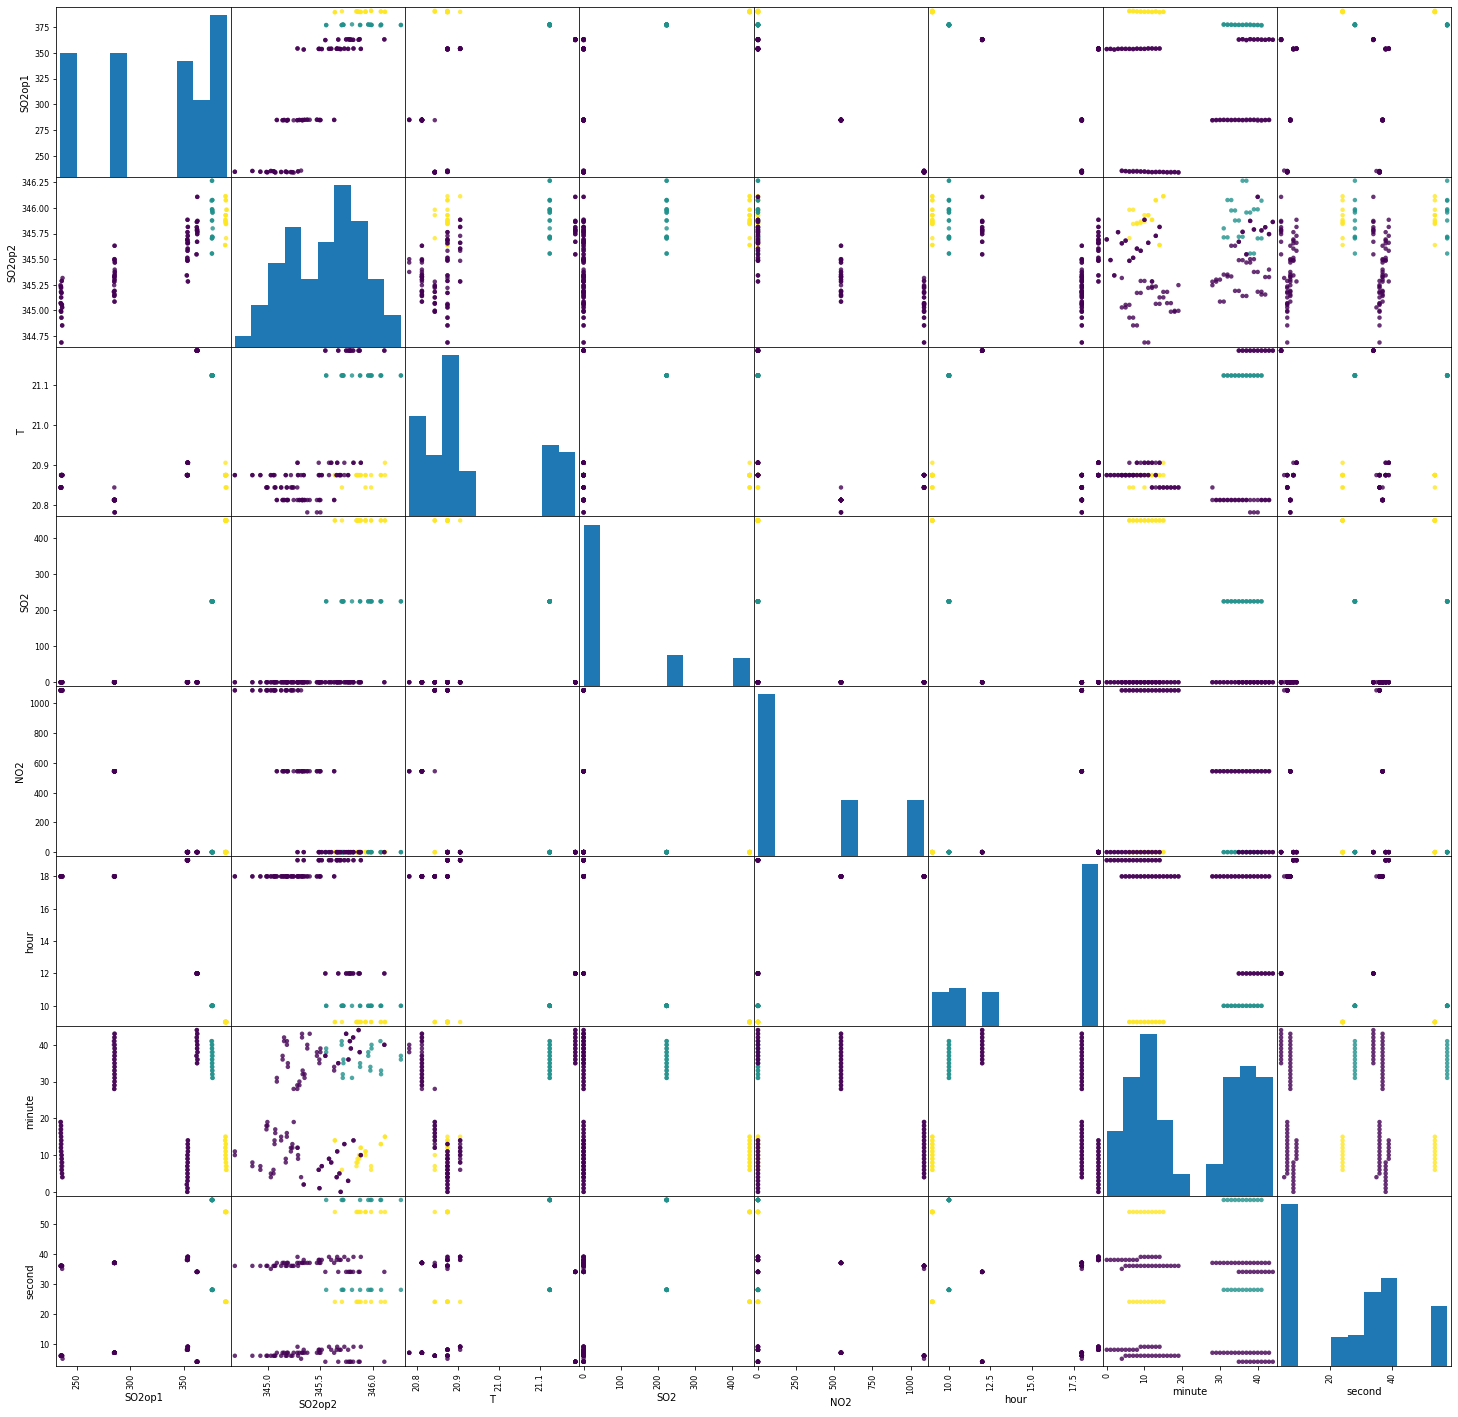

In [14]:
copyframe = calibration.copy() 
scatter_matrix(copyframe, c=copyframe['SO2'], figsize=(25,25), 
               marker='o', s=20, alpha=.8, cmap='viridis');

C:\Users\Alla\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\misc.py:100: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[j])
C:\Users\Alla\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\misc.py:101: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(boundaries_list[i])
C:\Users\Alla\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\misc.py:91: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[i])


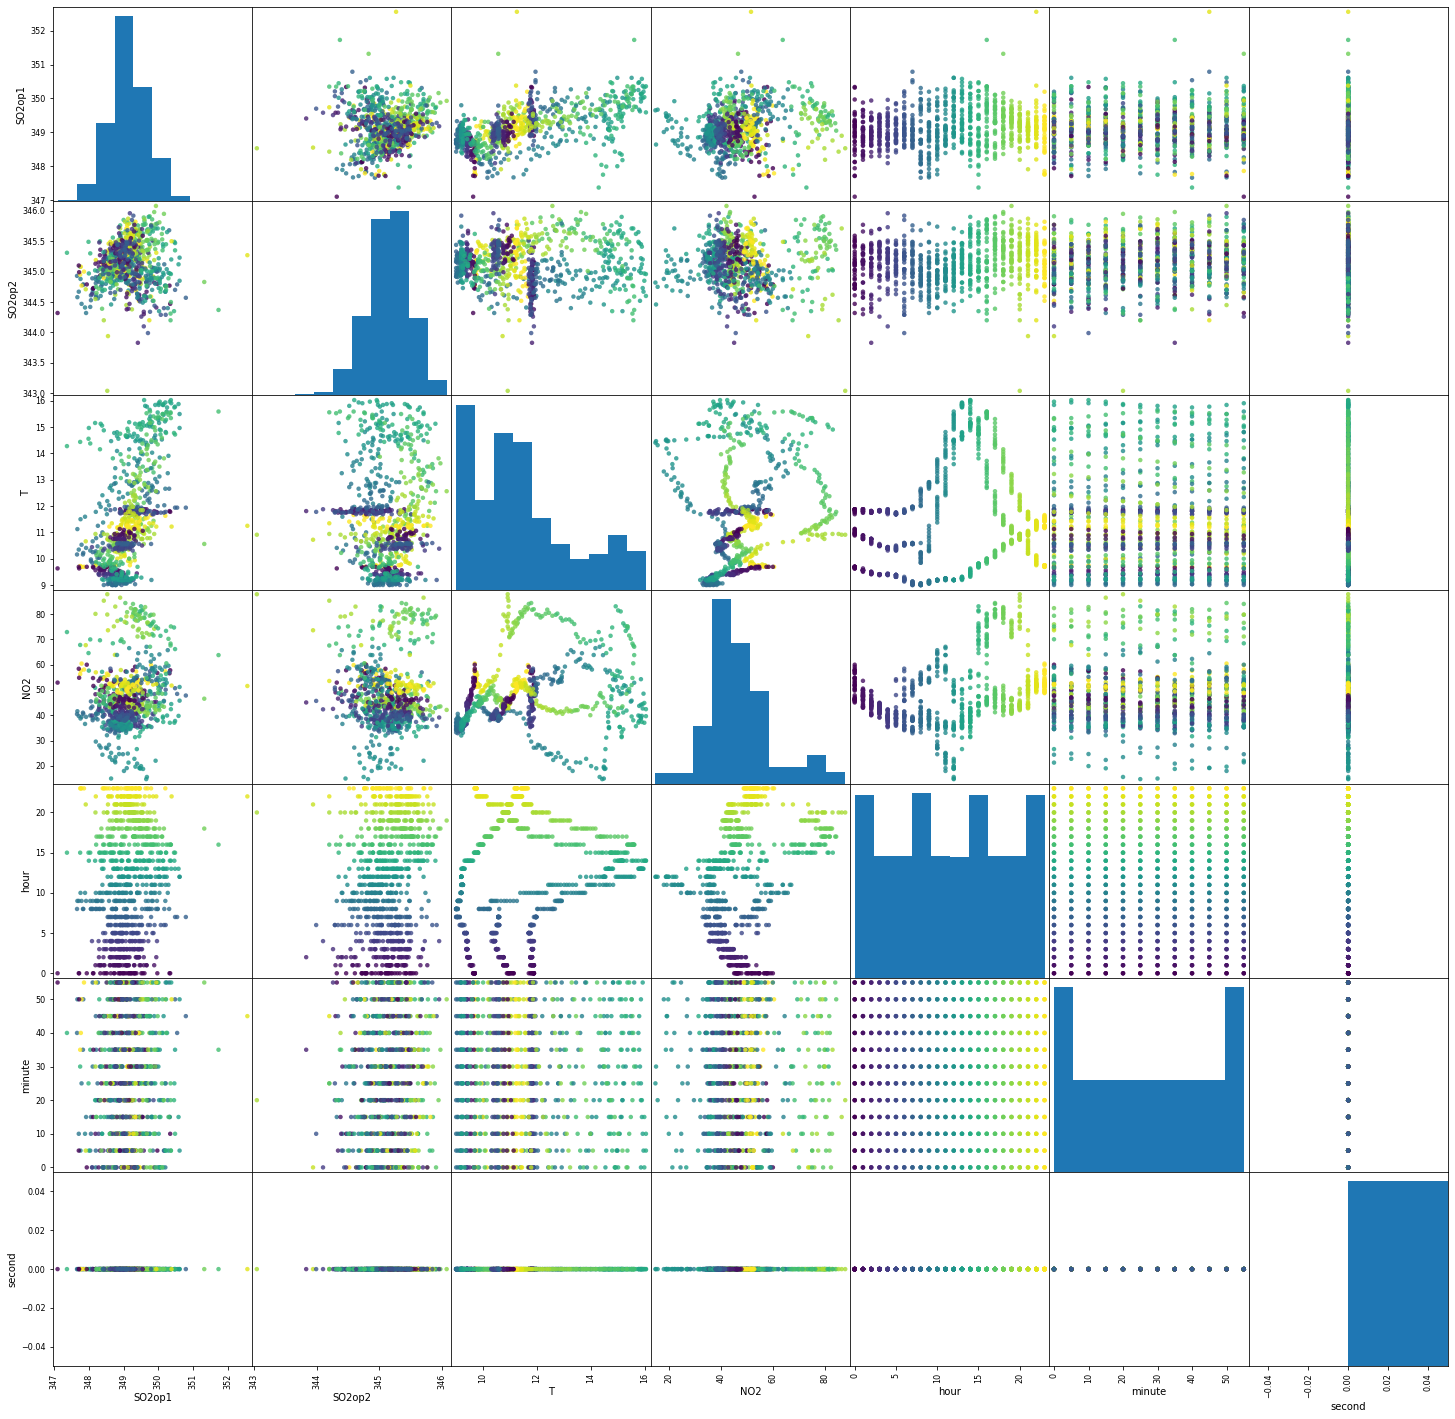

In [15]:
copyframe = test.copy() 
scatter_matrix(copyframe, c=copyframe['hour'], figsize=(25,25), 
               marker='o', s=20, alpha=.8, cmap='viridis');

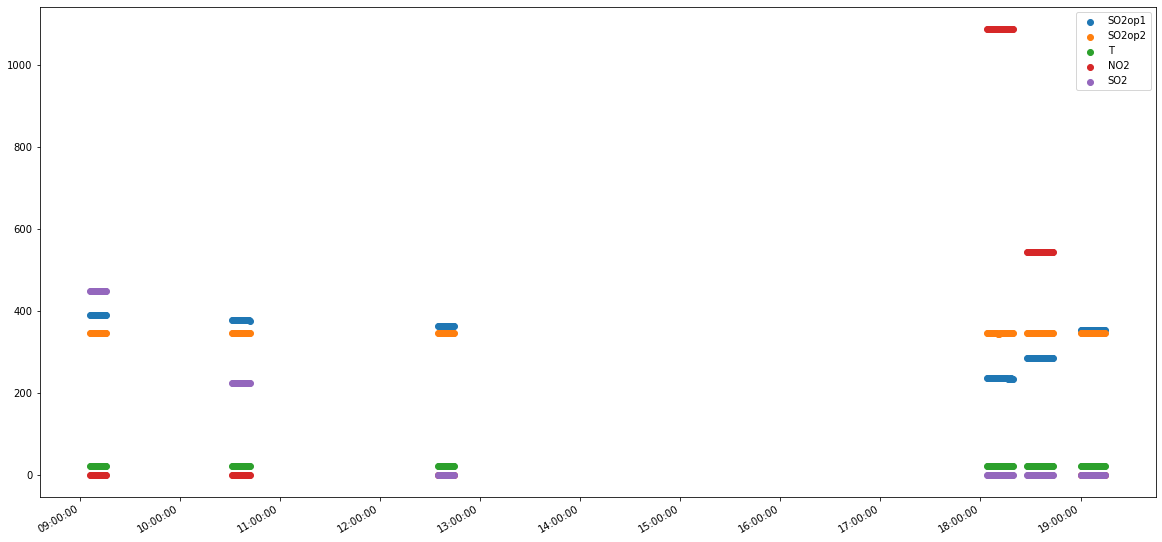

In [16]:
fig, ax = plt.subplots(figsize=(20, 10))
fmt = dates.DateFormatter('%H:%M:%S')
df = calibration.copy()
df['time_'] = df['time'].apply(lambda x: dt.datetime.strptime(x, "%H:%M:%S"))
plt.scatter(df['time_'], df['SO2op1'], label="SO2op1")
plt.scatter(df['time_'], df['SO2op2'], label="SO2op2")
plt.scatter(df['time_'], df['T'], label="T")
plt.scatter(df['time_'], df['NO2'], label="NO2")
plt.scatter(df['time_'], df['SO2'], label="SO2")
ax.xaxis.set_major_formatter(fmt)
ax.legend()
fig.autofmt_xdate()

#### Feature selection using automatic methods

Let's look at mutual information, which contains information about all dependencies - linear and nonlinear, and not just about the linear dependence, which is reflected by the correlation coefficient.

In [17]:
X = calibration[['SO2op1', 'SO2op2','T','NO2']]
y = calibration['SO2']

,SO2op1,SO2op2,T,NO2
0,0.775266,0.380655,0.555968,0.158461


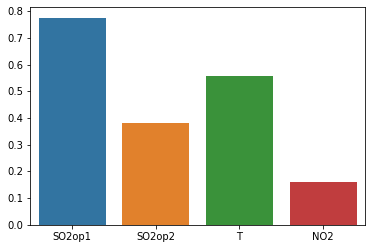

In [18]:
importances = mutual_info_classif(X, y)
feature_importances = pd.DataFrame([importances], columns=X.columns)
sns.barplot(data=feature_importances)
feature_importances

Thus, this test shows that the greatest dependence is present for the SO2op1 and T traits.

Let's look at VarianceThreshold, which selects features based on variance variation.

In [19]:
X_transform = VarianceThreshold(.7).fit_transform(X)
X_transform.shape

(156, 2)

VarianceThreshold selected SO2op1, NO2

### Regression

#### Linear regression

Let's test several linear models and not select features.

Since there is no target variable in the test, a short reference: the range of sulfur dioxide readings is 0 - 8000 μg/m3

In [20]:
def do_prediction(method, data_train: pd.DataFrame, features_train: List[str], data_test: pd.DataFrame) -> pd.DataFrame:
    """
    Make prediction of SO2 for certain method and train features.
    """        
    X = data_train[features_train]
    y = data_train['SO2']
    X_test = data_test[features_train]

    if isinstance(method, PolynomialFeatures):
        X_ = poly.fit_transform(X)
        predict_ = poly.fit_transform(X_test)
        reg = linear_model.LinearRegression()
        y_pred = reg.fit(X_, y).predict(predict_)

    else:
        y_pred = method.fit(X, y.values.ravel()).predict(X_test)
    prediction = data_test.copy()
    prediction['SO2'] = y_pred

    return prediction

In [21]:
def plot_prediction_from_time(prediction: pd.DataFrame, name_of_method: str):
    """
    Plot prediction of SO2 from time for certain method. The data is displayed separated by dates.
    """
    fig, ax = plt.subplots(figsize=(20, 10))
    fmt = dates.DateFormatter('%H:%M:%S')
    df = prediction.copy()
    df['time_'] = df['time'].apply(lambda x: dt.datetime.strptime(x, "%H:%M:%S"))
    sns.scatterplot(data=df, x='time_', y='SO2', hue='date')
    ax.xaxis.set_major_formatter(fmt) 
    ax.set_title(name_of_method)
    fig.autofmt_xdate()

In [22]:
def do_and_plot_prediction_for_many_models(data_train:  pd.DataFrame, features_train: List[str], 
                                           data_test: pd.DataFrame):
    """
    Make and plot prediction of SO2 for several methods and certain train features.
    """
    models = [LinearRegression(), Ridge(), Lasso(), SVR()]
    for model in models:
        prediction = do_prediction(method=model, data_train=data_train, features_train=features_train,
                                   data_test=data_test)
        plot_prediction_from_time(prediction, model)

In [23]:
def normalization(data: pd.DataFrame, features: List[str]) -> pd.DataFrame:
    """
    Do data normalization.
    """
    df = data.copy()
    for feature in features:
        df[feature] = (data[feature] - data[feature].min()) / (data[feature].max() - data[feature].min())
        
    return df

In [24]:
def standartization(data: pd.DataFrame, features: List[str]) -> pd.DataFrame:
    """
    Do data standartization.
    """
    df = data.copy()
    for feature in features:
        df[feature] = (data[feature] - data[feature].mean()) / data[feature].std()
        
    return df

#### Prediction on data without preprocessing

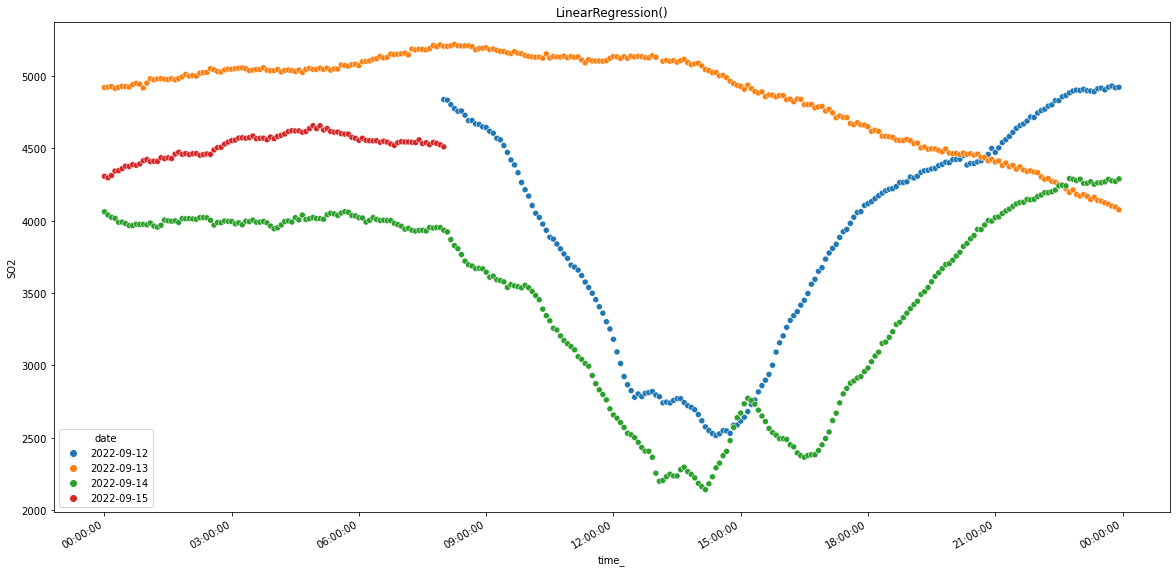

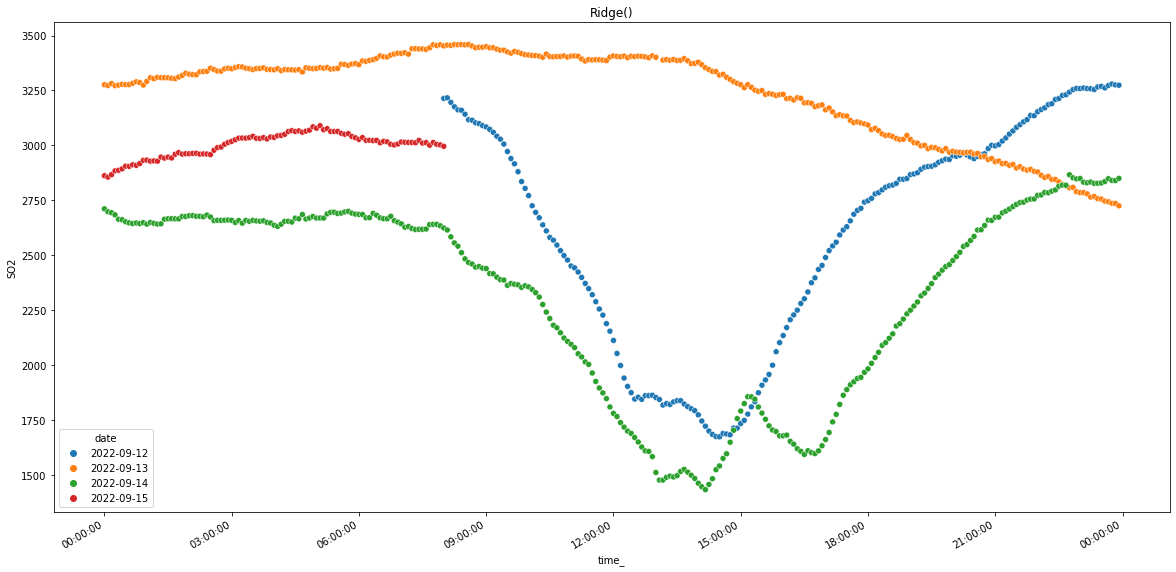

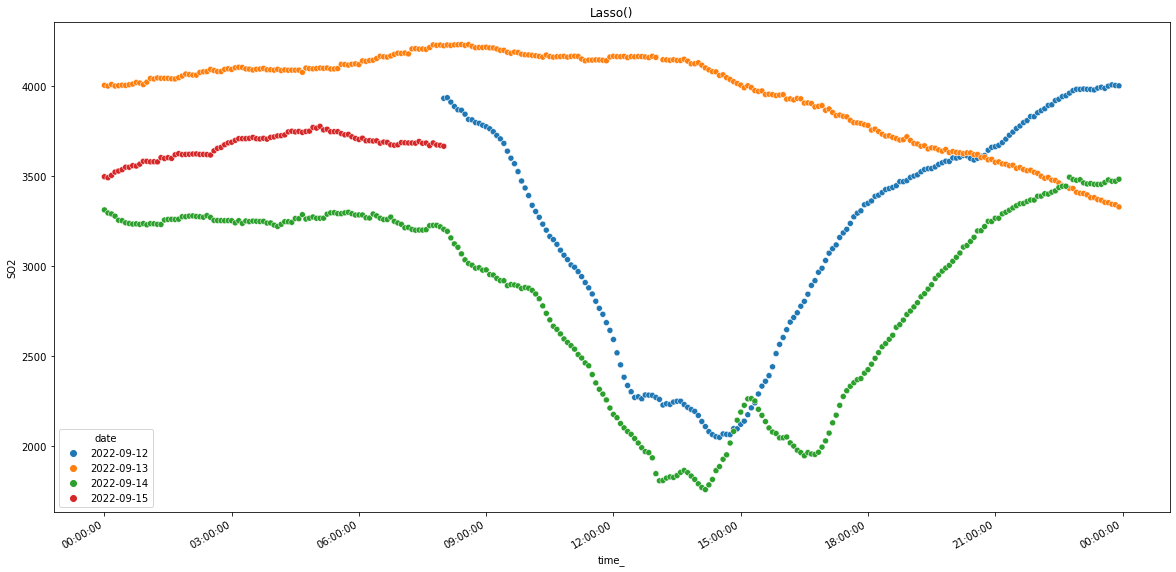

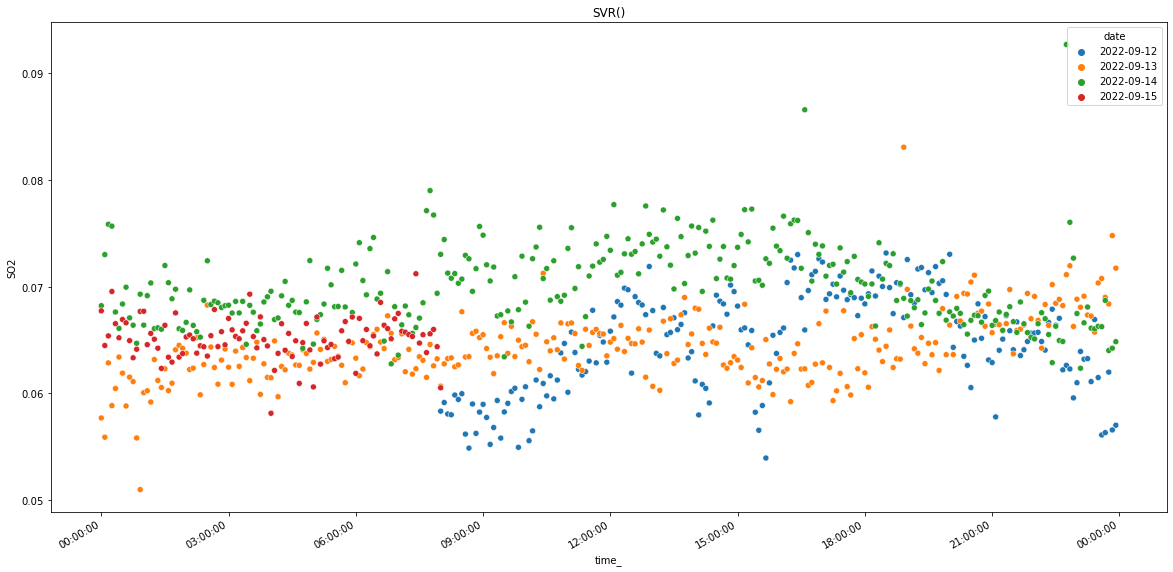

In [25]:
features_train = ['SO2op1', 'SO2op2', 'T', 'NO2']

do_and_plot_prediction_for_many_models(calibration, features_train, test)

#### Normalized data

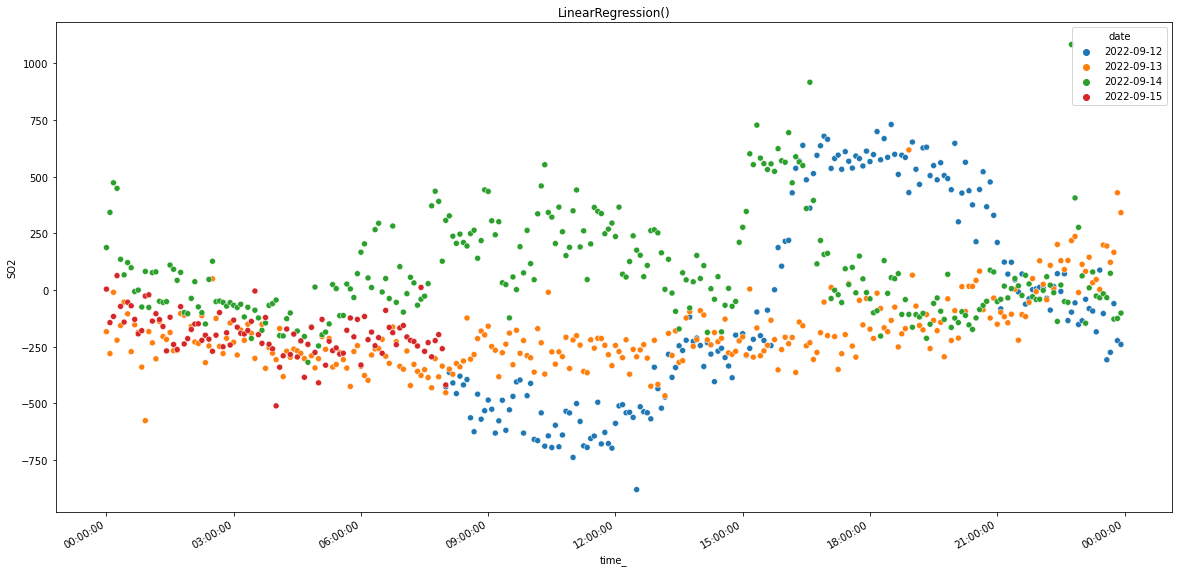

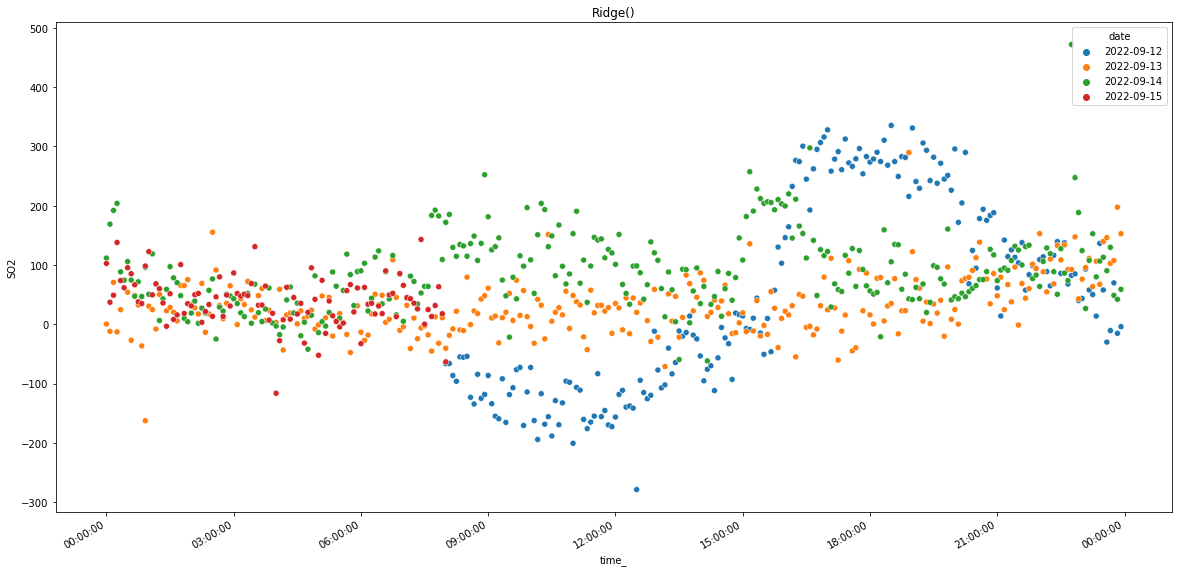

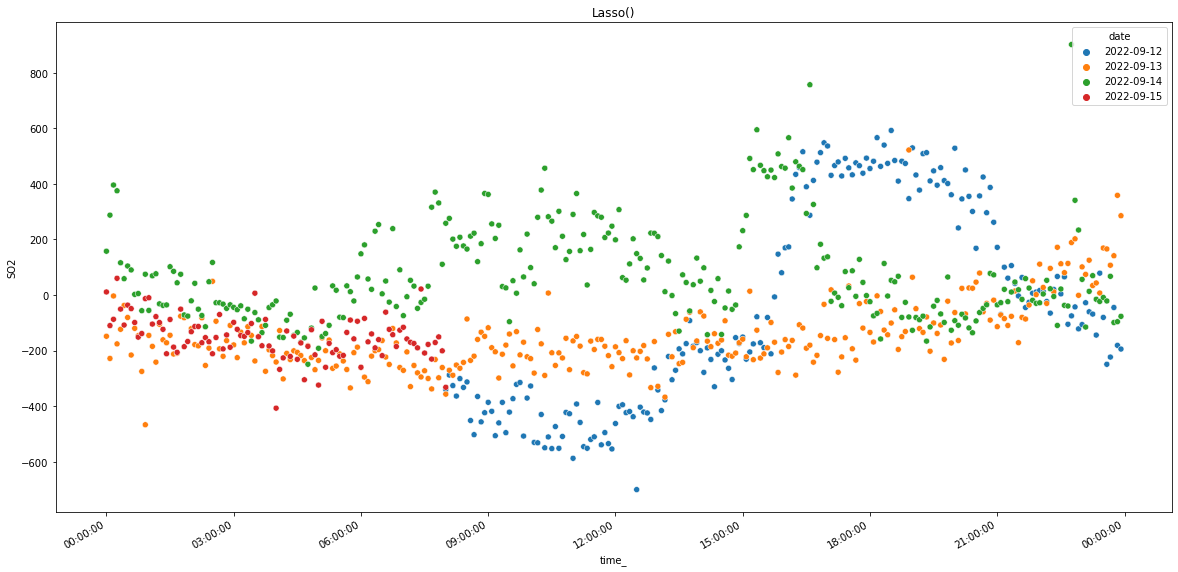

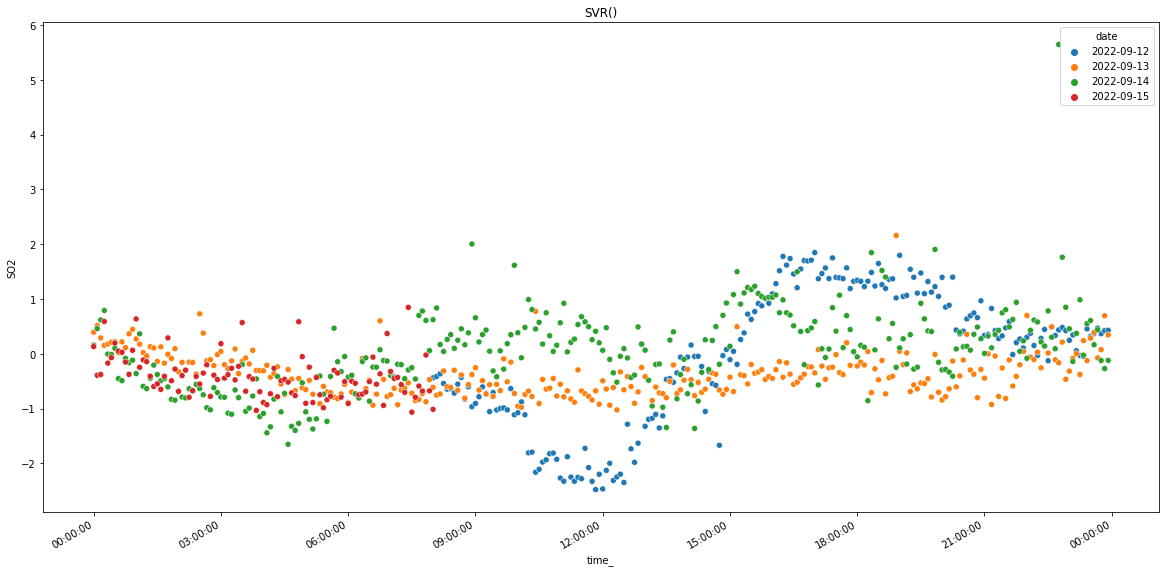

In [26]:
features_train = ['SO2op1', 'SO2op2', 'T', 'NO2']

calibration_normalized = normalization(calibration, features_train)
test_normalized = normalization(test, features_train)
do_and_plot_prediction_for_many_models(calibration_normalized, features_train, test_normalized)

#### Standardized

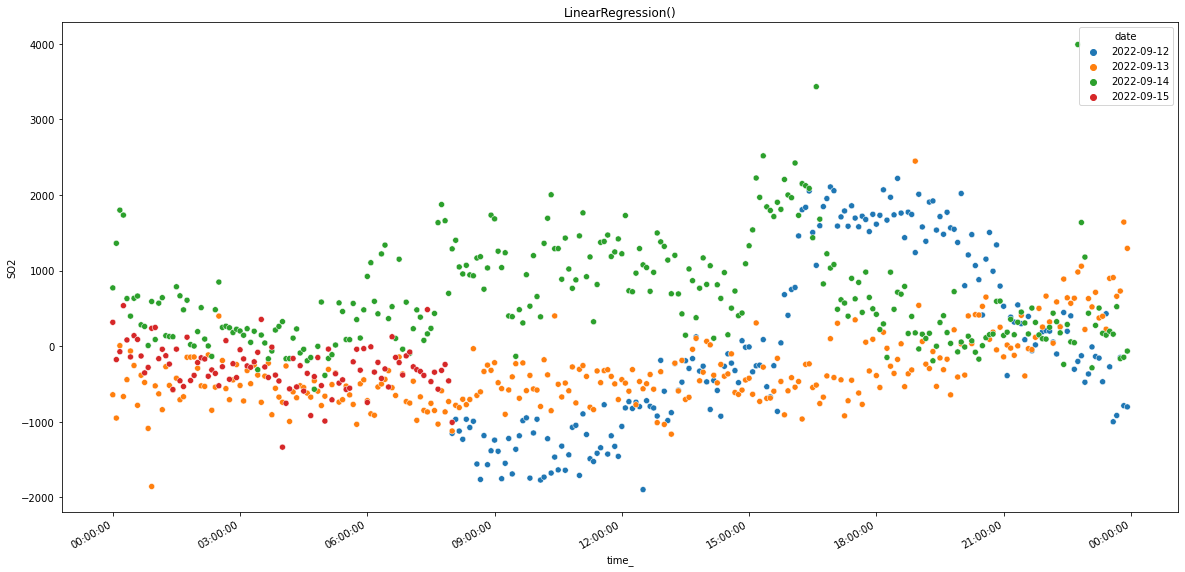

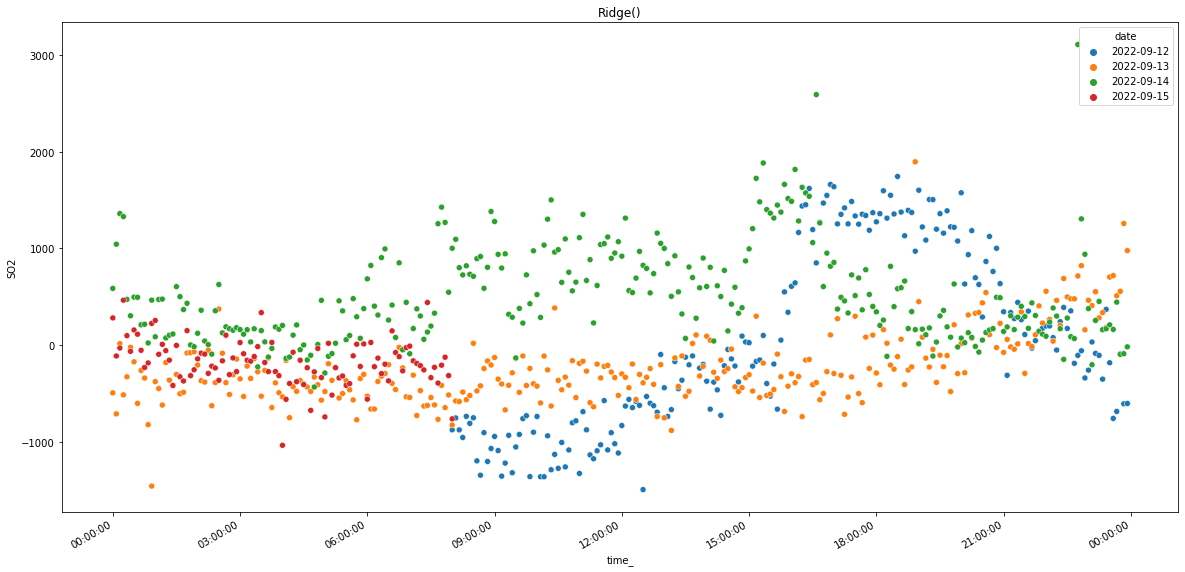

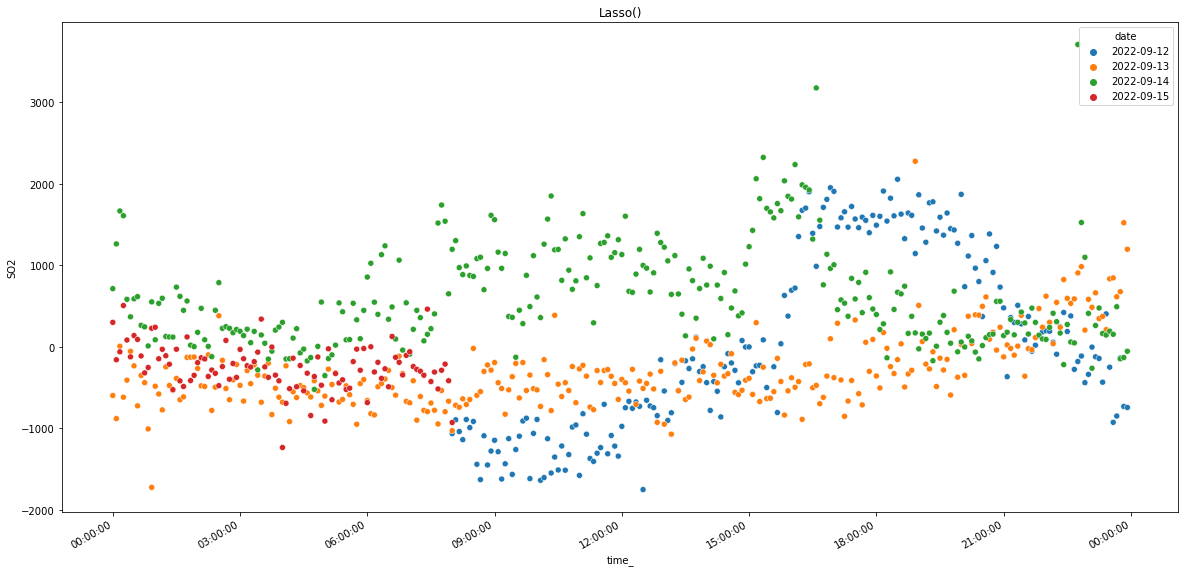

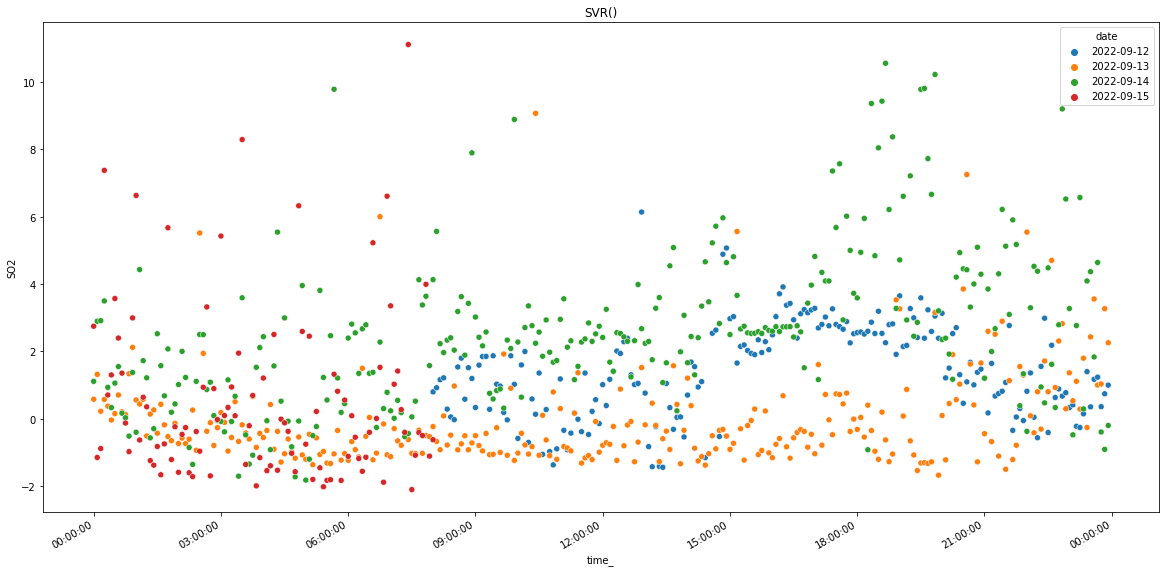

In [27]:
features_train = ['SO2op1', 'SO2op2', 'T', 'NO2']

calibration_standardized = standartization(calibration, features_train)
test_standardized = standartization(test, features_train)
do_and_plot_prediction_for_many_models(calibration_standardized, features_train, test_standardized)

On data without preprocessing, the first three methods have high prediction values. On the contrary, SVR has low values.

Normalization and standardization significantly change the result, however, negative values ​​appear in the predictions.

Let's try to use linear regression for the features we selected. Judging by the correlation coefficients, only the SO2op1 trait is suitable for linear regression.

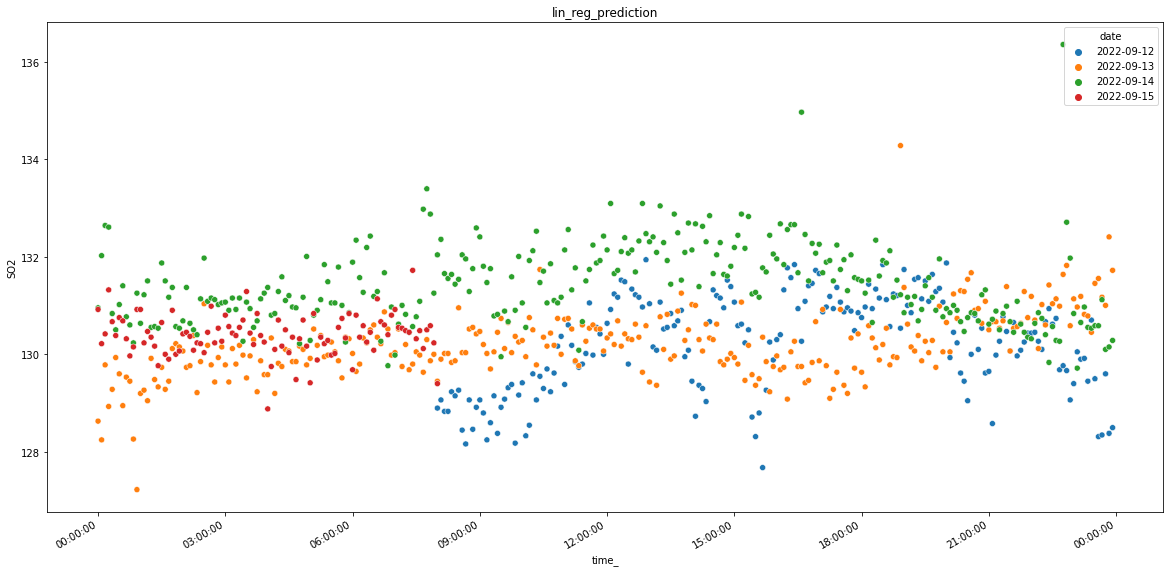

In [28]:
features_train = ['SO2op1']

lin_reg_prediction = do_prediction(method=LinearRegression(), data_train=calibration, features_train=features_train,
                                   data_test=test)
plot_prediction_from_time(lin_reg_prediction, 'lin_reg_prediction')

It is difficult to judge the result obtained without having the target variable in the test set, however, the result obtained for linear regression using one feature SO2op1 does not have negative values and falls within the range of values for SO2.

#### Polynomial regression

Below I will use polynomial regression, using a 2nd degree polynomial and one SO2op1 feature.

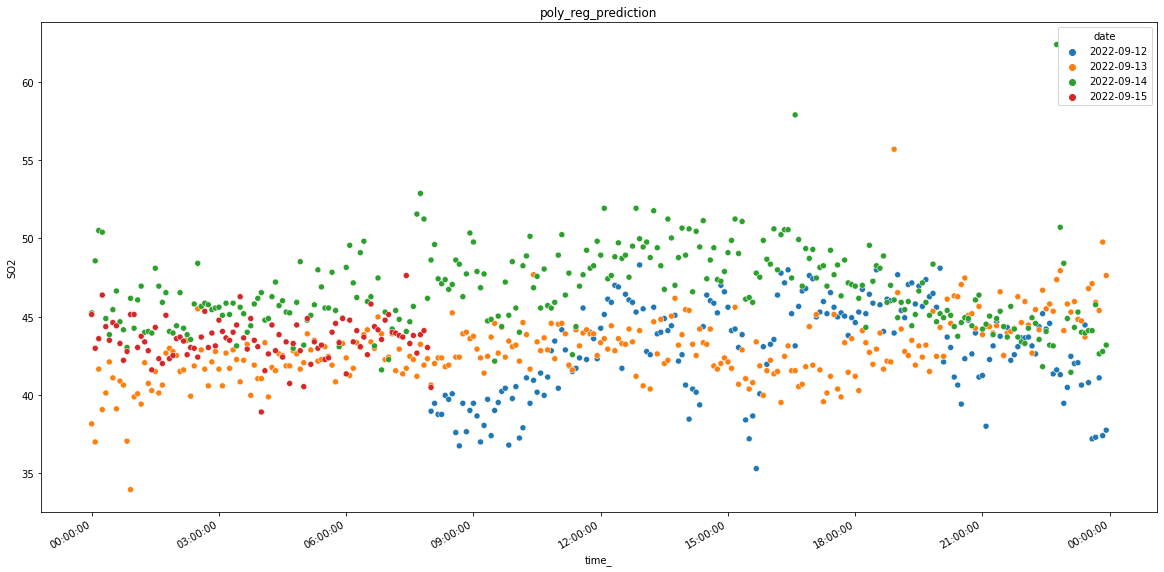

In [29]:
features_train = ['SO2op1']

poly = PolynomialFeatures(degree=2) # choose degree of polynom
poly_reg_prediction = do_prediction(method=poly, data_train=calibration, features_train=features_train, data_test=test)
plot_prediction_from_time(poly_reg_prediction, 'poly_reg_prediction')

The result also does not have negative values and falls within the range of SO2 values, however, it has lower values than the result in linear regression.

#### Errors between linear and polynomial models

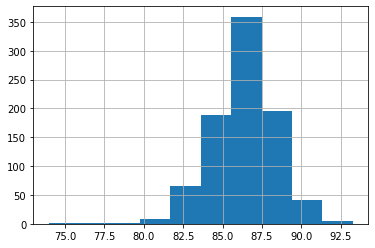

In [33]:
residuals = lin_reg_prediction['SO2'] - poly_reg_prediction['SO2']
residuals.hist()
plt.show()

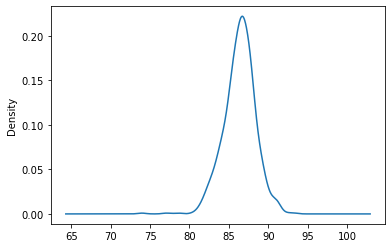

In [34]:
residuals.plot(kind='kde')
plt.show()

### Calculation of errors on the training set

In [35]:
def calculate_rmse(y_test: pd.DataFrame, y_pred: pd.DataFrame) -> float:
    """
    Calculate RMSE between true and predicted value of SO2.
    """
    
    return np.sqrt(mean_squared_error(y_test, y_pred))

In [36]:
def plot_true_and_predicted(y_pred: pd.Series):
    """
    Plot true and predicted value of SO2.
    """
    X_train, X_test, y_train, y_test = train_test_split(calibration, calibration['SO2'], test_size=0.3, random_state=42)
    time = X_test['time'].apply(lambda x: dt.datetime.strptime(x, "%H:%M:%S"))
    fig, ax = plt.subplots(figsize=(20, 10))
    fmt = dates.DateFormatter('%H:%M:%S')
    plt.scatter(time, y_pred, label='prediction')
    plt.scatter(time, y_test, label='true')
    ax.xaxis.set_major_formatter(fmt)
    plt.legend()
    fig.autofmt_xdate()

#### Linear regression

RMSE = 32.17425341686712


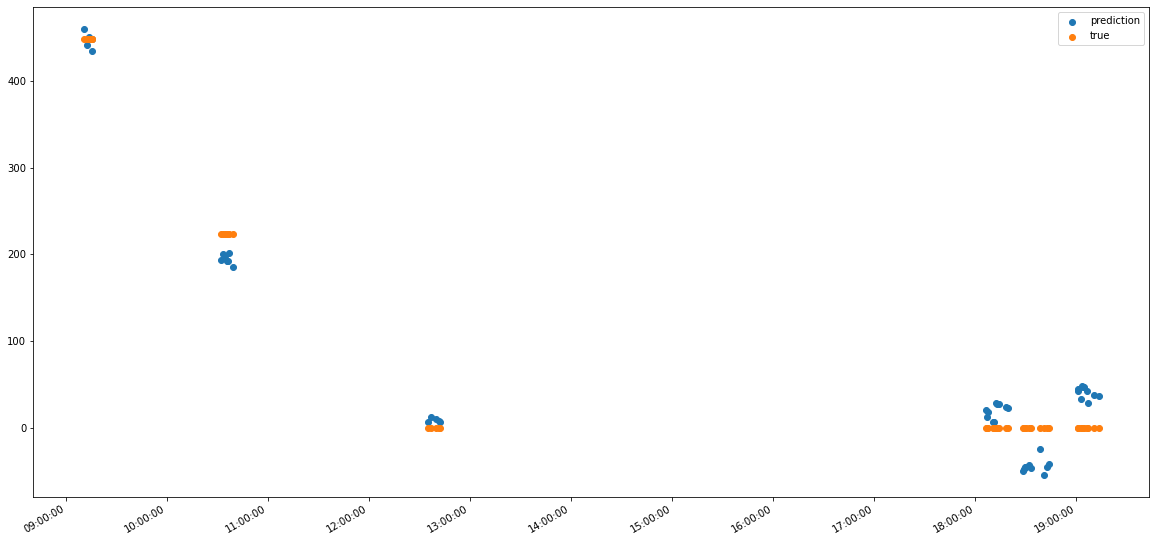

In [37]:
feature_train = ['SO2op1', 'SO2op2', 'T', 'NO2']

X_train, X_test, y_train, y_test = train_test_split(calibration, calibration['SO2'], test_size=0.3, random_state=42)
lin_reg_y_predicted = do_prediction(LinearRegression(), X_train,  feature_train, X_test)
plot_true_and_predicted(lin_reg_y_predicted['SO2'])
lin_reg_rmse = calculate_rmse(y_test, lin_reg_y_predicted['SO2'])
print('RMSE =', lin_reg_rmse)

#### Polynomial regression

RMSE = 2.3621412932438464


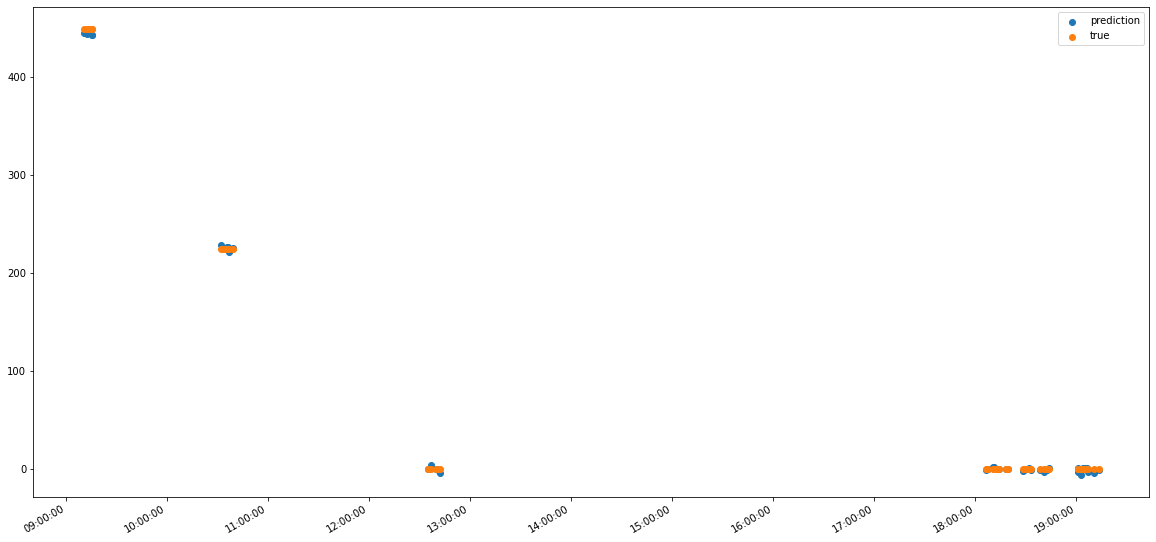

In [38]:
feature_train = ['SO2op1', 'SO2op2', 'T', 'NO2']

X = calibration[feature_train]
X_test = test[feature_train]

poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(poly_features, y, test_size=0.3, random_state=42)
poly_reg_model = LinearRegression()
poly_reg_model.fit(X_train, y_train)
poly_reg_y_predicted = poly_reg_model.predict(X_test)
plot_true_and_predicted(poly_reg_y_predicted)
poly_reg_rmse = calculate_rmse(y_test, poly_reg_y_predicted)
print('RMSE =', poly_reg_rmse)

This shows that the 2nd degree polynomial works better on the training sample RMSE = 2.36 versus RMSE = 32.17, however, this does not mean that this model will better predict SO2 values on the test sample, since it was noted that the training and test samples have differences, and some of the features of the training sample may not accurately reflect reality.

Comments on the samples have already been given above, but I would like to give a general comment, since this directly affects the result.

To ensure reliable results, the following three components are required:

•	Quantity. Sufficient data is important in order to train the model well.

•	Quality. Simply having data does not guarantee reliable results.

• Variety. Diversity will allow most, if not all, likely and possible cases to be modeled.
